# Toxicity Target Type Classification

In this notebook, we will train a baseline model to predict the type of a targeted toxic comment.

We will use [simpletransformers](https://simpletransformers.ai/) that is a wrapper for many popular models available in [Hugging Face](https://huggingface.co/).

We will use a pre-trained model ([neuralmind/bert-base-portuguese-cased · Hugging Face](https://huggingface.co/neuralmind/bert-base-portuguese-cased)) that is trained on Portuguese.

## Imports

In [1]:
import sys
from pathlib import Path

if str(Path(".").absolute().parent) not in sys.path:
    sys.path.append(str(Path(".").absolute().parent.parent))

In [2]:
from dotenv import load_dotenv

# Initialize the env vars
load_dotenv("../../.env")

True

In [3]:
import logging
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from torch.cuda import is_available
from sklearn.metrics import classification_report
from sklearn.utils.class_weight import compute_class_weight
from simpletransformers.classification import (
    ClassificationModel,
    ClassificationArgs
)

from src.kaggle import download_dataset
from src.modeling.utils import (
    prep_data,
    clean_simpletransformers
)

%matplotlib inline

sns.set_theme(style="whitegrid", palette="pastel")

logging.basicConfig(level=logging.INFO)

_logger = logging.getLogger("transformers")
_logger.setLevel(logging.WARNING)

params = {
    "seed": 1993,
    "model_type": "bert",
    "model_name": "neuralmind/bert-base-portuguese-cased",
    "num_train_epochs": 6,
    "use_cuda": is_available()
}

## Load the data

In this section, we will download the data and load it into a pandas dataframe.

In [4]:
files = download_dataset(
    ["train.csv", "test.csv"]
)

train_data = files["train.csv"]
test_data = files["test.csv"]

print(f"Training set: {train_data.shape}")
train_data.head()

Training set: (4765, 17)


,id,text,is_offensive,is_targeted,targeted_type,toxic_spans,health,ideology,insult,lgbtqphobia,other_lifestyle,physical_aspects,profanity_obscene,racism,religious_intolerance,sexism,xenophobia
0,430b13705cf34e13b74bc999425187c3,USER USER é muito bom. USER ^^ E claro a equip...,NOT,UNT,NaN,NaN,False,False,False,False,False,False,False,False,False,False,False
1,c779826dc43f460cb18e8429ca443477,Pior do que adolescentezinhas de merda...são p...,OFF,UNT,NaN,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",False,False,True,False,False,False,True,False,False,True,False
2,e64148caa4474fc79298e01d0dda8f5e,USER Toma no cu é vitamina como tu e tua prima.,OFF,TIN,GRP,"[5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17...",False,False,True,False,False,False,True,False,False,False,False
3,cc66b54eeec24607a67e2259134a1cdd,"Muito bom, pena a circunstâncias serem ruins, ...",OFF,UNT,NaN,"[119, 120, 121, 122, 123, 124, 125, 126, 127, ...",False,False,True,False,False,False,False,False,False,False,False
4,a3d7839456ae4258a70298fcf637952e,"Podia ter beijo também, pra ver se o homofóbic...",OFF,UNT,NaN,"[24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 3...",False,False,True,False,False,False,False,False,False,False,False


In [5]:
print(f"Test set: {test_data.shape}")
test_data.head()

Test set: (1589, 17)


,id,text,is_offensive,is_targeted,targeted_type,toxic_spans,health,ideology,insult,lgbtqphobia,other_lifestyle,physical_aspects,profanity_obscene,racism,religious_intolerance,sexism,xenophobia
0,da19df36730945f08df3d09efa354876,USER Adorei o comercial também Jesus. Só achei...,OFF,UNT,NaN,"[52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 6...",False,False,True,False,False,False,True,False,False,False,False
1,80f1a8c981864887b13963fed1261acc,Cara isso foi muito babaca geral USER conhece ...,OFF,TIN,GRP,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",False,False,True,False,False,False,False,False,False,False,False
2,2f67025f913e4a6292e3d000d9e2b5a8,"Se vc for porco, folgado e relaxado, você não ...",OFF,UNT,NaN,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",False,False,True,False,False,False,False,False,False,False,False
3,738ccd4476784f47af3a5a6cfdda4695,Se fosse um sniper ia ser louco,OFF,UNT,NaN,"[26, 27, 28, 29, 30]",False,False,True,False,False,True,False,False,False,False,False
4,e0064da693bd4c9e90ce8e6db8bd3bbb,USER é o meu saco USER USER USER,OFF,UNT,NaN,"[13, 14, 15, 16]",False,False,True,False,False,False,True,False,False,False,False


We need to filter only targeted toxic comments.

In [6]:
train_data = train_data[
    (train_data["is_offensive"] == "OFF") & \
        (train_data["is_targeted"] == "TIN") & \
            (train_data["targeted_type"].notnull())]

train_data.reset_index(drop=True, inplace=True)

test_data = test_data[
    (test_data["is_offensive"] == "OFF") & \
        (test_data["is_targeted"] == "TIN") & \
            (test_data["targeted_type"].notnull())]

test_data.reset_index(drop=True, inplace=True)

print(f"Training set: {train_data.shape}")
print(f"Test set: {test_data.shape}")

Training set: (2837, 17)
Test set: (946, 17)


## Exploratory Data Analysis (EDA)

In the next section, we will perform some exploratory data analysis (EDA) to understand the data.

In [7]:
df_eda = train_data[["text", "targeted_type"]].groupby("targeted_type").count()
df_eda.reset_index(inplace=True)
df_eda

,targeted_type,text
0,GRP,745
1,IND,1753
2,OTH,339


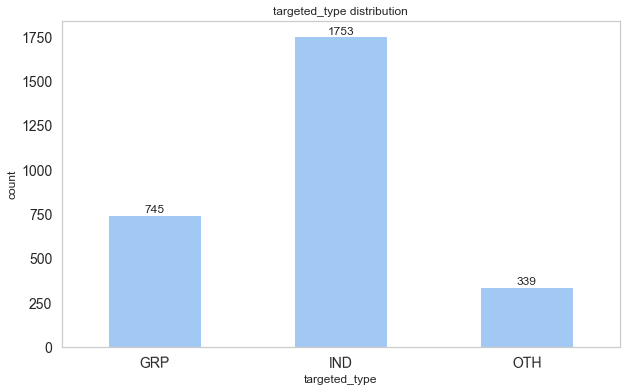

In [8]:
ax = df_eda.plot(x="targeted_type", y="text", kind="bar",
                 legend=False, figsize=(10, 6), grid=False,
                 xlabel="targeted_type", ylabel="count", fontsize=14,
                 rot=1, title="targeted_type distribution")

for container in ax.containers:
    ax.bar_label(container, fontsize=12)

In [9]:
classes = {
    0: "IND",
    1: "GRP",
    2: "OTH"
}

## Prepare the data

In this section, we will prepare the data in order to train the model.

The `simpletransformers` library expects the data in a specific format.

More information about the format can be found in the [Classification Data Formats - Simple Transformers](https://simpletransformers.ai/docs/classification-data-formats/#binary-classification)

In [10]:
X_train = train_data["text"].values
y_train = train_data["targeted_type"].values

X_test = test_data["text"].values
y_test = test_data["targeted_type"].values

train_data = prep_data(X_train, y_train, classes)
test_data = prep_data(X_test, y_test, classes)

df_train = pd.DataFrame(train_data)
df_train.columns = ["text", "labels"]

df_test = pd.DataFrame(test_data)
df_test.columns = ["text", "labels"]

print(f"train_data: {df_train.shape}")
print(f"test_data: {df_test.shape}")

train_data: (2837, 2)
test_data: (946, 2)


## Training the model

In this section, we will train a baseline model to predict if a toxic comment is targeted or not.

We will not perform hyperparameter tuning because it is a simple baseline model.

In [11]:
clean_simpletransformers()
        
# Compute class weights
params["class_weights"] = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y_train),
    y=y_train).tolist()

# Optional model configuration
model_args = ClassificationArgs(
    num_train_epochs=params["num_train_epochs"])

# Create a ClassificationModel
model = ClassificationModel(
    model_type=params["model_type"],
    model_name=params["model_name"],
    num_labels=len(np.unique(y_train)),
    args=model_args,
    weight=params["class_weights"],
    use_cuda=params["use_cuda"]
)

# Train the model
model.train_model(df_train)

Downloading:   0%|          | 0.00/647 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/438M [00:00<?, ?B/s]

Some weights of the model checkpoint at neuralmind/bert-base-portuguese-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the

Downloading:   0%|          | 0.00/43.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/210k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

  0%|          | 0/2837 [00:00<?, ?it/s]

Epoch:   0%|          | 0/6 [00:00<?, ?it/s]

Running Epoch 0 of 6:   0%|          | 0/355 [00:00<?, ?it/s]

Running Epoch 1 of 6:   0%|          | 0/355 [00:00<?, ?it/s]

Running Epoch 2 of 6:   0%|          | 0/355 [00:00<?, ?it/s]

Running Epoch 3 of 6:   0%|          | 0/355 [00:00<?, ?it/s]

Running Epoch 4 of 6:   0%|          | 0/355 [00:00<?, ?it/s]

Running Epoch 5 of 6:   0%|          | 0/355 [00:00<?, ?it/s]

(2130, 0.3105427133776149)

## Evaluating the model

In this section, we will evaluate the model with the following metrics:

- **Accuracy**: the percentage of correct predictions;
- **Precision**: the percentage of predicted targeted comments that are actually targeted;
- **Recall**: the percentage of targeted comments that are actually predicted as targeted;
- **F1-Score**: the harmonic mean of precision and recall;
- **ROC AUC**: the area under the receiver operating characteristic Curve (ROC AUC).

In [12]:
result, model_outputs, wrong_predictions = model.eval_model(df_test)

y_true = df_test["labels"].tolist()

y_pred, raw_outputs = model.predict(df_test["text"].tolist())

result

  0%|          | 0/946 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/119 [00:00<?, ?it/s]

  0%|          | 0/946 [00:00<?, ?it/s]

  0%|          | 0/119 [00:00<?, ?it/s]

{'mcc': 0.5673619166894018, 'eval_loss': 1.4005593216074084}

In [13]:
print(
    classification_report(
        y_test, pd.Series(y_pred).map(classes).values,
        digits=4, zero_division=0
    )
)

              precision    recall  f1-score   support

         GRP     0.6304    0.6808    0.6546       213
         IND     0.8647    0.8604    0.8626       609
         OTH     0.5909    0.5242    0.5556       124

    accuracy                         0.7759       946
   macro avg     0.6953    0.6885    0.6909       946
weighted avg     0.7761    0.7759    0.7755       946



## Testing the model

In the last section, we will test the model with some comments from the test set.

In [14]:
df_pred = df_test.head(20)

predictions, raw_outputs = model.predict(df_pred["text"].tolist())

df_pred = df_pred.assign(predictions=predictions)

df_pred["labels"] = df_pred["labels"].map(classes)
df_pred["predictions"] = df_pred["predictions"].map(classes)

df_pred.to_csv("pred.csv", index=False, encoding="utf-8")

df_pred

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

,text,labels,predictions
0,Cara isso foi muito babaca geral USER conhece ...,GRP,OTH
1,"USER Que vagabunda hipócrita, pq eu beijei as ...",IND,IND
2,"USER USER, exatamente. E quem abusa pra caralh...",GRP,GRP
3,Não vai arrumar trabalho nem de limpar bosta d...,IND,IND
4,"O diabo é sujo mesmo, ele tem orgulho de conta...",IND,IND
5,"A podridão vindo a tona, USER está fazendo tud...",GRP,GRP
6,'esse partido chamado P T e esse P Sol sao uma...,IND,IND
7,RT USER: Lula e o PT estavam mortos e enterrad...,IND,GRP
8,A KATE E O BABACA DOS BRIDGERTON MLK VEM AI OS...,IND,GRP
9,A USER ESCOLHEU O USER USER PARA HUMILHAR O US...,IND,IND


In [ ]:
clean_simpletransformers()